In [1]:
import pyterrier as pt

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

if not pt.started():
  pt.init()

PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [2]:
dataset = pt.datasets.get_dataset("vaswani")

In [3]:
topics = dataset.get_topics()
topics

,qid,query
0,1,measurement of dielectric constant of liquids ...
1,2,mathematical analysis and design details of wa...
2,3,use of digital computers in the design of band...
3,4,systems of data coding for information transfer
4,5,use of programs in engineering testing of comp...
...,...,...
88,89,tunnel diode construction and its electrical c...
89,90,electronic density of states at the surface of...
90,91,resistivity of metallic thin films related to ...
91,92,the phenomenon of radiation caused by charged ...


In [4]:
with open(dataset.get_corpus()[0], "r") as f:
    content = f.read()

docs = re.findall(r'<DOC>\s*<DOCNO>(\d+)</DOCNO>\s*(.*?)\s*</DOC>', content, flags=re.DOTALL)

df = pd.DataFrame(docs, columns=["docno", "text"])
df["docno"] = df["docno"].astype(int)

df.head()

,docno,text
0,1,compact memories have flexible capacities a d...
1,2,an electronic analogue computer for solving sy...
2,3,electronic coordinate transformer circuit det...
3,4,the british computer society report of a conf...
4,5,millimicrosecond digital computer logic a sys...


In [5]:
df.shape

(11429, 2)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(df["text"])

In [8]:
vectors.shape

(11429, 12163)

In [9]:
def query_likelihood_retrieval(vectorizer, vectors, query, collection=False):
    
    query_array = vectorizer.transform([query]).toarray()
    query_array = (query_array != 0).reshape(-1)
    
    if collection:
        vectors = np.asarray(vectors.sum(axis=0))
        
    p_vectors = (vectors / vectors.sum(axis=1))
    return np.asarray(p_vectors[:, query_array].prod(axis=1)).reshape(-1)

In [10]:
query = "electronic"
P_Q_D_ql = query_likelihood_retrieval(vectorizer, vectors, query)
P_Q_C_ql = query_likelihood_retrieval(vectorizer, vectors, query, collection=True)

In [11]:
P_Q_C_ql

array([0.00064335])

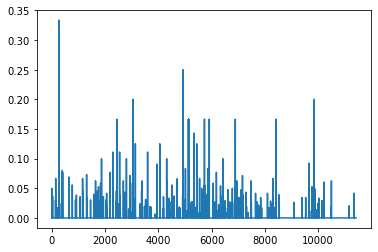

(11429,)

In [12]:
plt.plot(P_Q_D_ql)
plt.show()

P_Q_D_ql.shape

In [13]:
def cluster_based_retrieval(vectorizer, vectors, clusters, mu, query):
    
    len_vectores = vectors.shape[0]
    P_w_D = np.zeros(len_vectores)
    Nds = np.asarray(vectors.sum(axis=1))
    
    for d in range(len_vectores):
        Nd = Nds[d]
        vectors_cluster = vectors[clusters == clusters[d]]
        P_w_D[d] = (Nd / (Nd + mu)) * query_likelihood_retrieval(vectorizer, vectors[d], query) + (1 - (Nd / (Nd + mu))) * query_likelihood_retrieval(vectorizer, vectors_cluster, query, collection=True)
    
    return P_w_D

In [14]:
from sklearn.cluster import KMeans

In [15]:
k_means = KMeans(n_clusters=len(topics), verbose=False, random_state=0)

In [16]:
k_means.fit(vectors)
clusters = k_means.labels_

In [17]:
query = "electronic"
P_Q_D_cluster = cluster_based_retrieval(vectorizer, vectors, clusters, 1000, query)

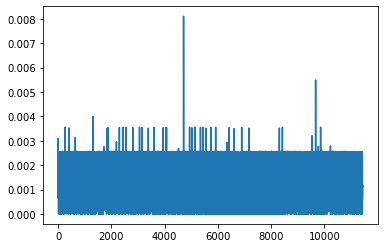

(11429,)

In [18]:
plt.plot(P_Q_D_cluster)
plt.show()

P_Q_D_cluster.shape

In [ ]:
def lda_based_retrieval(vectorizer, vectors, alpha, beta, lamb, mu, query):
    pass